# Part 3 - Producing a MySQL Database

## Business Problem

Create a database to analyze what makes a movie successful, and will provide recommendations to the stakeholder on how to make a successful movie. 

### Specifications - Database

* Take data that has been cleaned and create a MySQL database. 

* Normalize the tables before adding them to the new database. 
    
    * All data from the TMDB API should be in 1 table together (even though it will not be perfectly normalized).
    
    *Keep only imdb_id, revenue, budget, and certification columns.

## Transformation Steps:

* Normalize Genre:

    * Convert the single string of genres from title_basics into 2 new tables.         
        1. title_genres: with columns:
            * tconst
            * genre_id
        
        2. genres:
            * genre_id
            * genre_name


* Discard unnecessary information:

    * For the title basics table, drop the following columns:
        * "original_title" (we will use the primary title column instead)
        * "isAdult" ("Adult" will show up in the genres so this is redundant information).
        * "titleType" (every row will be a movie).
        * "genres" and other variants of genre (genre is now represented in the 2 new tables described above.
     
    * Do not include the title_akas table in your SQL database.
        * You have already filtered out the desired movies using this table and the remaining data is mostly nulls and not of-interest to the stakeholder.

## MySQL Database Requirements

* Use sqlalchemy with pandas to execute your SQL queries inside your notebook.


* Create a new database on your MySQL server and call it "movies".



* Make sure to have the following tables in your "movies" database:

    * title_basics
    * title_ratings
    * title_genres
    * genres
    * tmdb_data


* Make sure to set a Primary Key for each table that isn't a joiner table (e.g. title_genres is a joiner table).


* After creating each table, show the first 5 rows of that table using a SQL query.


* Make sure to run the "SHOW TABLES" SQL query at the end of your notebook to show that all required tables have been created.

### Deliverables

Submit a link to your github respository containing the Jupyter Notebook file.



# Getting Started Tips

## Normalizing Genres - Overview

* In order to normalize genres, we will need to:

    * Convert the single string of genres from title basics into 2 new tables.
        
        1. title_genres: with the columns:

            * tconst
            * genre_id
        
        2. genres:
            * genre_id
            * genre_name


* Creating these tables will be a multi-step process.

    
    
        1. Getting a list of all individual genres.
    
    
        2. Create a new title_genres table with with the movie ids duplicated, once for each genre that a movie belongs to.
    
    
        3. Create a mapper dictionary with numeric ids for each genre.
    
    
        4. Use the mapper dictionary to replace the string genres in title_genres with numeric genre_ids.
    
    
        5. Convert the mapper dictionary into a final genres table with the numeric genre_id and the string genre.

### 1. Getting List of Unique Genres:

* The genres column should be separated into separate genres.

    * For example: "Comedy,Fantasy,Romance" is actually 3 genres that the movie belongs to, not one combined-genre.


* First, you will need to get a list of all of the unique genres that appear in the column. Right now, the genre column contains a string with the genres separated by a comma.

    1. We are going to convert these strings into lists of strings into a new 'genres_split' column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

pd.set_option('display.max_columns',100)

In [2]:
FOLDER = "Data/"
sorted(os.listdir(FOLDER))

['final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json']

In [11]:
# Concatenate the DataFrames
import glob
q  = f"{FOLDER}final*.csv.gz"
files = sorted(glob.glob(q))
files

['Data\\final_tmdb_data_2000.csv.gz', 'Data\\final_tmdb_data_2001.csv.gz']

In [16]:
df = pd.concat([pd.read_csv(f, lineterminator='\n') for f in files] )
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification\r
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\r
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,3.133,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 60, 'logo_path': '/2eqFolQI0NLL7ExZts5...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,\r
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,1.878,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 925, 'logo_path': '/dIb9hjXNOkgxu4kBWd...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,\r
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",1.400,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.000,0.0,\r
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",23.683,/iYypPT4bhqXfq1b6EnmxvRt6b2Y.jpg,"[{'id': 539, 'logo_path': None, 'name': 'Block...","[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",2000-09-29,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.107,1926.0,PG\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,tt7797670,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956214.0,en,Edmund Kemper Part 2: La Mort C'est La Vie,Underground French necrophilia nastiness,0.841,/2Xh5ywVZJC5OxKYDS26fVJfC8zq.jpg,"[{'id': 139554, 'logo_path': None, 'name': 'Am...","[{'iso_3166_1': 'FR', 'name': 'France'}]",2001-01-01,0.0,91.0,[],Released,NaN,Edmund Kemper Part 2: La Mort C'est La Vie,0.0,0.000,0.0,\r
1282,tt7797790,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,956219.0,en,Edmund Kemper Part 3: La mort sévit,Underground French necrophilia nastiness,0.600,/75kV4BpVnXe2kAMsWAKxx466M88.jpg,"[{'id': 139554, 'logo_path': None, 'name': 'Am...","[{'iso_3166_1': 'FR', 'name': 'France'}]",2001-01-01,0.0,72.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,Edmund Kemper Part 3: La mort sévit,0.0,0.000,0.0,\r
1283,tt8665056,0.0,NaN,NaN,0.0,"[{'id': 37, 'name': 'Western'}]",http://skeletoncreekproductions.com/p-movie-br...,885436.0,en,Guns Along The Bravo,In the 1880's a ruthess gang of outlaws terroi...,1.341,NaN,"[{'id': 68934, 'logo_path': None, 'name': 'Ske...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-10-10,0.0,85.0,[],Released,Evil came to the Southwest until three blazing...,Guns Along The Bravo,0.0,0.000,0.0,\r
1284,tt8795764,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",https://www.utahwolf.com/films/coming-soon-new...,871624.0,en,New Breed,Derek gets sucked into a gothic cult that turn...,0.600,/goddglRmgDgQuo9tlMdoeeHlRfX.jpg,"[{'id': 133614, 'logo_path': None, 'name': 'Wo...","[{'iso_3166_1': 'US', 'name': 'United States o...",2001-01-01,0.0,57.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",

,# null,% null,# unique,% unique
imdb_id,0,0.00,2489,99.96
adult,2,0.08,2,0.08
backdrop_path,1214,48.76,1276,51.24
belongs_to_collection,2294,92.13,173,6.95
budget,2,0.08,178,7.15
genres,2,0.08,540,21.69
homepage,2316,93.01,174,6.99
id,2,0.08,2488,99.92
original_language,2,0.08,52,2.09
original_title,2,0.08,2482,99.68


C:\Users\nbeac\anaconda3\envs\dojo-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\nbeac\anaconda3\envs\dojo-env\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


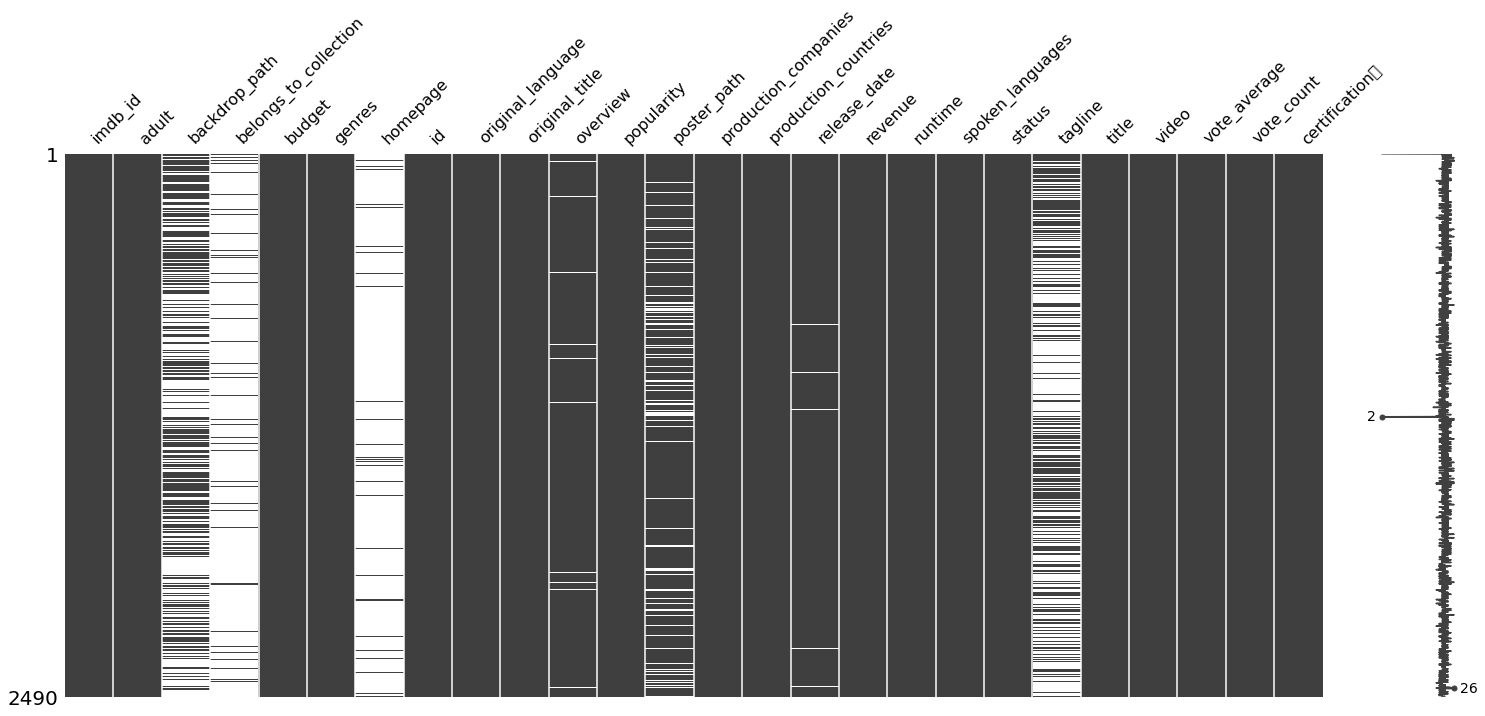

In [10]:
def check_nulls_nunique(df,plot=True):
    """Displays a df summary of the # & % of null values and unique values for each column.
    Args:
        df (DataFrame): Frame to check
        plot (bool, optional): Whether to plot missingo.matrixs. Defaults to True.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import missingno

    report = pd.DataFrame({"# null":df.isna().sum(),
                "% null":df.isna().sum()/len(df)*100,
                '# unique':df.nunique(),
                        '% unique':df.nunique()/len(df)*100})
    display(report.round(2))
    if plot:
        missingno.matrix(df)
        plt.show()
check_nulls_nunique(df)